In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from IPython.core.display import clear_output
!pip install sklearn_crfsuite 'scikit-learn<0.24' eli5
clear_output()

In [3]:
!gdown --id 1bZv65xa-ybRsIqrtuFfh2ffyJaTPMTzG

Downloading...
From: https://drive.google.com/uc?id=1bZv65xa-ybRsIqrtuFfh2ffyJaTPMTzG
To: /content/ner_dataset.zip
100% 188k/188k [00:00<00:00, 69.9MB/s]


In [4]:
!unzip ner_dataset.zip

Archive:  ner_dataset.zip
   creating: ner_dataset/
  inflating: ner_dataset/data_ann_2000.csv  
  inflating: ner_dataset/data_ann_2010.csv  


In [3]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
style.use('seaborn')

import numpy as np

import nltk
from nltk.tokenize import sent_tokenize
import eli5
import sklearn_crfsuite
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report

import sklearn
from sklearn.feature_extraction import DictVectorizer
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer

from itertools import chain
import scipy.stats


Using TensorFlow backend.


## EDA

In [4]:
data1 = pd.read_csv("ner_dataset/data_ann_2000.csv")
data2 = pd.read_csv("ner_dataset/data_ann_2010.csv")

data = pd.concat([data1, data2], ignore_index=True)
data.head()

,Unnamed: 0,Text,POS,Tag,Abstract
0,0,Centroidal,NN,B-ALGO,0.0
1,1,Voronoi,NN,I-ALGO,0.0
2,2,Tesselation,NN,I-ALGO,0.0
3,3,(,(,O,0.0
4,4,CVT,NN,B-ALGO,0.0


In [5]:
data.shape

(33394, 5)

In [6]:
data.isna().sum()

Unnamed: 0    0
Text          1
POS           0
Tag           0
Abstract      0
dtype: int64

In [7]:
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [8]:
data.Abstract = data.Abstract.astype('int64')

In [9]:
data.Tag.value_counts()

O          30556
B-FIELD      805
I-FIELD      486
I-ALGO       355
B-ALGO       302
B-STAN       198
B-PLAT       156
B-API        139
B-FRAM        96
I-PLAT        82
B-PL          56
I-STAN        50
I-API         43
I-FRAM        35
I-PL          19
B-PENT        12
I-PENT         3
Name: Tag, dtype: int64

Всего в данных 17 тегов на тему компьютерных наук



*   **PL**: Programming language (C++, Java, Python…)
*   **FRAM**: Tool, library or framework (Tensorflow, Microsoft Word, OpenCV…)
*   **STAN**: Computer standard (CSV, TXT, compiler…)
*   **PLAT**: Plateform (GPU, x86, Cloud Computer…)
*   **API**: Classes, event, functions or data structures (graph, init(), print(), object…)
*   **PENT**: Physical entity involved in CS field (Google, Microsoft, CNRS…)
*   **ALGO**: Algorithms (Dijkstra, KNN, Monte Carlo Search…)
*   **FIELD**: Field of application (Machine Learning, Robotic, security…)


Распределены они очень несбалансированно

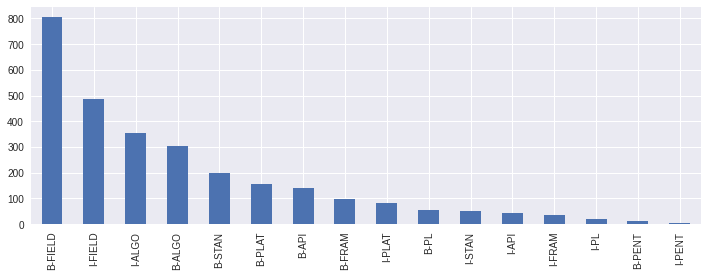

In [10]:
plt.figure(figsize=(12,4))
data[data.Tag != 'O'].Tag.value_counts().plot(kind='bar')

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Каждому слову и тегу в соответствие ставится не номер предложения, а номер аннотации из статьи - можно разделить их на предложения

In [12]:
abstracts = data.groupby('Abstract')['Text'].apply(lambda x: " ".join([i for i in x]))
abstracts

Abstract
0      Centroidal Voronoi Tesselation ( CVT ) of poin...
1      A family of Jordan arcs such that two arcs are...
2      Control in distributed systems is mainly intro...
3      We customize here for the purposes of precompu...
4      The work of nurse anaesthetists is carried out...
                             ...                        
109    Deep Neural Networks have the generic layers a...
110    A decision support system is needed by local g...
111    Intracranial hemorrhage ( ICH ) is an acute - ...
112    This paper presents a muscle gesture - compute...
113    The activities of human can be classified into...
Name: Text, Length: 114, dtype: object

In [13]:
tmp_sent = []
for text in abstracts:
  tmp_sent += sent_tokenize(text)

In [164]:
print("Количество предложений:", len(tmp_sent))

Количество предложений: 1390


In [15]:
data.shape

(33393, 5)

In [16]:
data['Sentence'] = 0

In [17]:
count = 0
for i, sent in enumerate(tmp_sent):
    for j in sent.split():
      data.loc[count, 'Sentence'] = i
      count+=1

In [18]:
create_group = lambda x: [(w, tag, tok) for w, tag, tok in zip(x.Text, x.POS, x.Tag)]
sentences = data.groupby('Sentence')[['Text',	'POS', 'Tag']].apply(create_group).values
sentences[0][:5]

[('Centroidal', 'NN', 'B-ALGO'),
 ('Voronoi', 'NN', 'I-ALGO'),
 ('Tesselation', 'NN', 'I-ALGO'),
 ('(', '(', 'O'),
 ('CVT', 'NN', 'B-ALGO')]

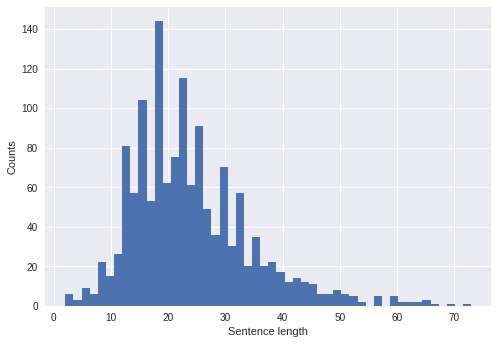

In [19]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('Sentence length')
plt.ylabel('Counts')
plt.show()

В среднем длина предложения - 20 слов

## CRF

### Baseline

In [138]:
train_data, test_data = train_test_split(sentences, test_size=0.2, random_state=42)

In [139]:
train_data = train_data.tolist()
test_data = test_data.tolist()

print(len(train_data))
print(len(test_data))

1112
278


In [140]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

X_train = [sent2features(s) for s in train_data]
y_train = [sent2labels(s) for s in train_data]

X_test = [sent2features(s) for s in test_data]
y_test = [sent2labels(s) for s in test_data]

In [143]:
X_train[0][0]

{'+1:postag': 'IN',
 '+1:postag[:2]': 'IN',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': 'for',
 'BOS': True,
 'bias': 1.0,
 'postag': 'NN',
 'postag[:2]': 'NN',
 'word.isdigit()': False,
 'word.istitle()': False,
 'word.isupper()': False,
 'word.lower()': 'template',
 'word[-3:]': 'ate'}

In [144]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=False
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

Т.к. большинство тэгов это 'Out', который нас не особо интересует, будем считать скор только по остальным тегам

In [145]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-FIELD',
 'I-FIELD',
 'I-PLAT',
 'B-PLAT',
 'B-STAN',
 'B-ALGO',
 'I-ALGO',
 'B-FRAM',
 'B-PENT',
 'B-PL',
 'I-PL',
 'B-API',
 'I-STAN',
 'I-API',
 'I-FRAM',
 'I-PENT']

In [146]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


0.5372909613717944

In [147]:
pred = cross_val_predict(estimator=crf, X=X_train, y=y_train, cv=5)
report = flat_classification_report(y_pred=pred, y_true=y_train)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

      B-ALGO       0.73      0.39      0.50       236
       B-API       0.59      0.20      0.30       110
     B-FIELD       0.74      0.53      0.62       652
      B-FRAM       0.82      0.27      0.41        84
      B-PENT       1.00      0.17      0.29        12
        B-PL       0.67      0.13      0.22        46
      B-PLAT       0.67      0.28      0.40       131
      B-STAN       0.68      0.28      0.39       152
      I-ALGO       0.71      0.42      0.53       286
       I-API       0.25      0.03      0.05        34
     I-FIELD       0.63      0.47      0.54       362
      I-FRAM       0.00      0.00      0.00        32
      I-PENT       0.00      0.00      0.00         3
        I-PL       0.00      0.00      0.00        17
      I-PLAT       0.70      0.32      0.44        66
      I-STAN       0.33      0.09      0.14        33
           O       0.95      0.99      0.97     24387

    accuracy              

Text(0, 0.5, 'Count')

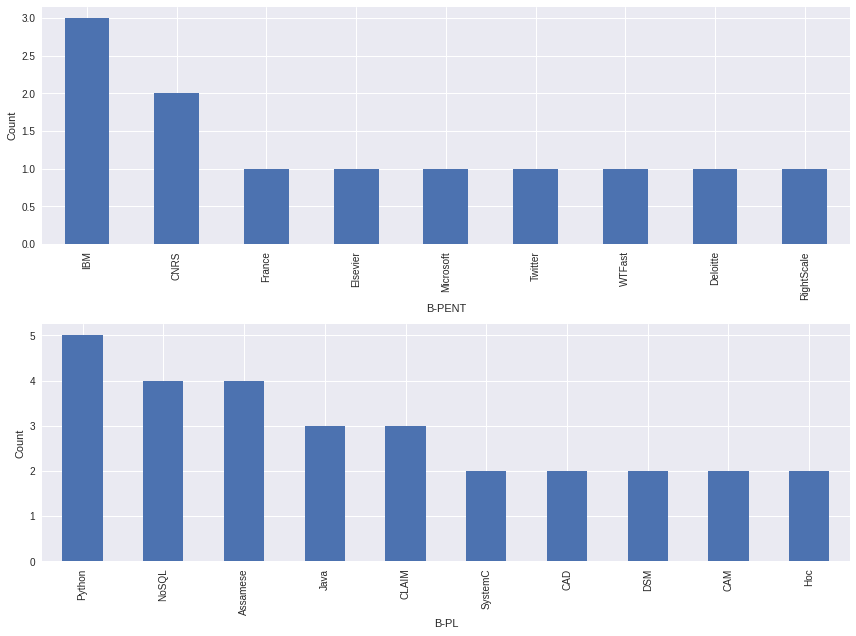

In [148]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
data[data.Tag == 'B-PENT'].Text.value_counts()[:10].plot(kind='bar')
plt.xlabel('B-PENT')
plt.ylabel('Count')
plt.tight_layout()
plt.subplot(2,1,2)
data[data.Tag == 'B-PL'].Text.value_counts()[:10].plot(kind='bar')
plt.xlabel('B-PL')
plt.ylabel('Count')

Было предсказуемо, что признаки "начинается ли слово с заглавной буквы" и "содержит ли слово символы только верхнего регистра" будут мало полезны в этой задаче - большинство исследуемых нами слов начинаются с большой буквы или являются аббревиатурами, но принадлежат разным классам

### Tuning

Попробуем использовать словари сущностей, которые предоставляются вместе с датасетом: https://www.kaggle.com/madjakul/computer-science-gazetteers

In [191]:
!gdown --id 17c1pxVMcS9ny4UzveM1ig1M67HXbwIUw

Downloading...
From: https://drive.google.com/uc?id=17c1pxVMcS9ny4UzveM1ig1M67HXbwIUw
To: /content/gazetteers.zip
100% 49.5k/49.5k [00:00<00:00, 50.6MB/s]


In [192]:
!unzip gazetteers.zip

Archive:  gazetteers.zip
  inflating: ALGO.txt                
  inflating: FIELD.txt               
  inflating: FRAM.txt                
  inflating: PENT.txt                
  inflating: PL.txt                  
  inflating: PLAT.txt                
  inflating: STAN.txt                


In [149]:
api = data[data.Tag == 'B-API'].Text.unique().tolist() + \
      data[data.Tag == 'I-API'].Text.unique().tolist()

In [150]:
entity_dict = {'ALGO': [], 'FIELD': [], 'FRAM': [], 'PENT': [], 'PL': [], 'PLAT': [], 'STAN': []}
for k in entity_dict.keys():
  with open('{}.txt'.format(k), 'r') as f:
    for line in f:
      entity_dict[k].append(line.strip())


In [151]:
entity_dict['API'] = api

In [152]:
def check_entity_in_dict(entity):
  for k, v in entity_dict.items():
    for w in v:
      if entity in w.split():
        return k
  return 'out'

In [153]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    entity = check_entity_in_dict(word)

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
        'entity': entity
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        entity1 = check_entity_in_dict(word1)
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:entity': entity1
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        entity1 = check_entity_in_dict(word1)
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:entity': entity1
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

X_train = [sent2features(s) for s in train_data]
y_train = [sent2labels(s) for s in train_data]

X_test = [sent2features(s) for s in test_data]
y_test = [sent2labels(s) for s in test_data]

In [112]:
X_train[0][0]

{'+1:entity': 'ALGO',
 '+1:postag': 'IN',
 '+1:postag[:2]': 'IN',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': 'for',
 'BOS': True,
 'bias': 1.0,
 'entity': 'out',
 'postag': 'NN',
 'postag[:2]': 'NN',
 'word.isdigit()': False,
 'word.istitle()': False,
 'word.isupper()': False,
 'word.lower()': 'template',
 'word[-3:]': 'ate'}

Сразу на кросс-валидации попробуем подобрать параметры регуляризации

In [116]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=False
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)
# Fitting 3 folds for each of 50 ca

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.0min finished


CPU times: user 10min 36s, sys: 2.22 s, total: 10min 38s
Wall time: 18min 7s


In [117]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.04400228058002249, 'c2': 0.005527775458776378}
best CV score: 0.5118625724885951
model size: 0.37M


In [154]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=rs.best_params_['c1'],
    c2=rs.best_params_['c2'],
    max_iterations=100,
    all_possible_transitions=False,
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.04400228058002249,
    c2=0.005527775458776378, keep_tempfiles=None, max_iterations=100)

In [155]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


0.5493123875829449

In [156]:
pred = cross_val_predict(estimator=crf, X=X_train, y=y_train, cv=5)
report = flat_classification_report(y_pred=pred, y_true=y_train)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

      B-ALGO       0.71      0.42      0.52       236
       B-API       0.56      0.30      0.39       110
     B-FIELD       0.71      0.59      0.65       652
      B-FRAM       0.89      0.39      0.55        84
      B-PENT       1.00      0.17      0.29        12
        B-PL       0.67      0.26      0.38        46
      B-PLAT       0.66      0.39      0.49       131
      B-STAN       0.66      0.33      0.44       152
      I-ALGO       0.66      0.42      0.52       286
       I-API       0.67      0.24      0.35        34
     I-FIELD       0.60      0.49      0.54       362
      I-FRAM       0.00      0.00      0.00        32
      I-PENT       0.00      0.00      0.00         3
        I-PL       0.00      0.00      0.00        17
      I-PLAT       0.67      0.39      0.50        66
      I-STAN       0.36      0.15      0.21        33
           O       0.96      0.99      0.97     24387

    accuracy              

Большого улучшения не произошло, но некоторые категории стали распознаваться лучше (например 'B-PENT')

Визуализируем результаты алгоритма:

In [ ]:
!pip install ipymarkup
clear_output

In [202]:
from ipymarkup import show_ascii_markup
from ipymarkup import show_box_markup

In [213]:
for sent in range(3):
  text = " ".join([x[0] for x in train_data[sent]])
  start = 0
  spans = []
  for i, w in enumerate(train_data[sent]):
    end = start+len(w[0])+1
    if pred[sent][i] != 'O':
      spans.append((start, end, pred[sent][i]))
    start=end

  show_box_markup(text, spans)

В целом неплохо справляется, иногда путая обычные слова с API и находя не все сущности

## Neural Networks

## LSTM

Будем строить Bi-LSTM

In [20]:
import numpy as np
import pandas as pd
import keras

from subprocess import check_output

from future.utils import iteritems
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

clear_output()

In [21]:
data.Tag.value_counts()

O          30556
B-FIELD      805
I-FIELD      486
I-ALGO       355
B-ALGO       302
B-STAN       198
B-PLAT       156
B-API        139
B-FRAM        96
I-PLAT        82
B-PL          56
I-STAN        50
I-API         43
I-FRAM        35
I-PL          19
B-PENT        12
I-PENT         3
Name: Tag, dtype: int64

Хотелось разбить данные на стратифицированные обучающую и тестовую выборку, но объектов сущности PENT для этого слишком мало <br>

In [22]:
data = data[data.Tag != 'B-PENT']
data = data[data.Tag != 'I-PENT']

In [24]:
create_group = lambda x: [(w, tok) for w, tok in zip(x.Text, x.Tag)]
sentences = data.groupby('Sentence')[['Text',	'Tag']].apply(create_group).values
sentences[0][:5]

[('Centroidal', 'B-ALGO'),
 ('Voronoi', 'I-ALGO'),
 ('Tesselation', 'I-ALGO'),
 ('(', 'O'),
 ('CVT', 'B-ALGO')]

In [25]:
maxlen = max([len(s) for s in sentences])
print('Maximum sequence length:', maxlen)

Maximum sequence length: 73


In [26]:
words = list(set(data["Text"].values))
words.append("ENDPAD")

In [27]:
n_words = len(words)
n_words

5631

In [28]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

15

In [29]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [30]:
X_idx = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X_idx, padding="post",value=n_words - 1)

y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y_idx, padding="post", value=tag2idx["O"])

In [31]:
print(sentences[100])
print(y_idx[100])

[('input', 'O'), ('photos', 'O'), ('.', 'O'), ('The', 'O'), ('recursive', 'B-ALGO'), ('method', 'I-ALGO'), ('formalized', 'O'), ('by', 'O'), ('Nijenhuis', 'O'), ('and', 'O'), ('Wilf', 'O'), ('and', 'O'), ('systematized', 'O'), ('by', 'O'), ('Flajolet', 'O'), ('Van', 'O'), ('Cutsem', 'O'), ('and', 'O'), ('Zimmermann', 'O'), ('is', 'O'), ('extended', 'O'), ('here', 'O'), ('to', 'O')]
[12, 12, 12, 12, 5, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]


In [32]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
def create_model():
  input = Input(shape=(maxlen,))
  model = Embedding(input_dim=n_words, output_dim=140, input_length=maxlen)(input)
  model = Dropout(0.1)(model)
  model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
  out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
  return Model(input, out)

In [35]:
model = create_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [36]:
adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss="categorical_crossentropy", 
              metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [37]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 73)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 73, 140)           788340    
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 140)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 73, 200)           192800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 73, 15)            3015      
Total params: 984,155
Trainable params: 984,155
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(X_train, np.array(y_train), batch_size=8, epochs=10, validation_split=0.1, verbose=1)


Train on 1000 samples, validate on 112 samples
Epoch 1/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.3366 - precision_1: 0.9736 - recall_1: 0.8955 - val_loss: 0.1759 - val_precision_1: 0.9689 - val_recall_1: 0.9689
Epoch 2/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.1330 - precision_1: 0.9733 - recall_1: 0.9726 - val_loss: 0.1466 - val_precision_1: 0.9728 - val_recall_1: 0.9676
Epoch 3/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.1007 - precision_1: 0.9849 - recall_1: 0.9697 - val_loss: 0.1329 - val_precision_1: 0.9810 - val_recall_1: 0.9659
Epoch 4/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0838 - precision_1: 0.9925 - recall_1: 0.9695 - val_loss: 0.1319 - val_precision_1: 0.9835 - val_recall_1: 0.9653
Epoch 5/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0742 - precision_1: 0.9947 - recall_1: 0.9705 - val_loss: 0.1349 - val_precision_1: 0.9839 - val

In [39]:
p = model.predict(np.array(X_test))  

In [40]:
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),
                            labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

      I-STAN       0.00      0.00      0.00        17
      B-PLAT       0.42      0.40      0.41        25
        B-PL       0.00      0.00      0.00        10
       B-API       0.62      0.28      0.38        29
     B-FIELD       0.56      0.56      0.56       153
      B-ALGO       0.56      0.36      0.44        66
      I-FRAM       0.00      0.00      0.00         3
        I-PL       0.00      0.00      0.00         2
       I-API       0.00      0.00      0.00         9
     I-FIELD       0.62      0.32      0.43       124
      I-ALGO       0.65      0.38      0.48        69
      I-PLAT       0.50      0.06      0.11        16
           O       0.98      0.99      0.99     19713
      B-FRAM       0.30      0.25      0.27        12
      B-STAN       0.67      0.26      0.38        46

    accuracy                           0.98     20294
   macro avg       0.39      0.26      0.30     20294
weighted avg       0.97   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
labels = list(tags)
labels.remove('O')
labels

['I-STAN',
 'B-PLAT',
 'B-PL',
 'B-API',
 'B-FIELD',
 'B-ALGO',
 'I-FRAM',
 'I-PL',
 'I-API',
 'I-FIELD',
 'I-ALGO',
 'I-PLAT',
 'B-FRAM',
 'B-STAN']

In [42]:
y_pred = model.predict(np.array(X_test))
f1_score(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),
                      average='weighted', labels=[tag2idx[i] for i in labels])

0.4204816085262177

In [43]:
y_pred = model.predict(np.array(X_test))
f1_score(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),
                      average='weighted')

0.9733128965967559

### LSTM with class weights

Целевые категории несбалансированы, разница в количестве объектов разных категорий слишком большая, поэтому попробуем добавлять веса

In [44]:
data.Tag.value_counts()

O          30556
B-FIELD      805
I-FIELD      486
I-ALGO       355
B-ALGO       302
B-STAN       198
B-PLAT       156
B-API        139
B-FRAM        96
I-PLAT        82
B-PL          56
I-STAN        50
I-API         43
I-FRAM        35
I-PL          19
Name: Tag, dtype: int64

In [82]:
weights = (1 / data.Tag.value_counts()) * (data.shape[0] / 2.0)
weights

O            0.546178
B-FIELD     20.731677
I-FIELD     34.339506
I-ALGO      47.011268
B-ALGO      55.261589
B-STAN      84.287879
B-PLAT     106.980769
B-API      120.064748
B-FRAM     173.843750
I-PLAT     203.524390
B-PL       298.017857
I-STAN     333.780000
I-API      388.116279
I-FRAM     476.828571
I-PL       878.368421
Name: Tag, dtype: float64

In [83]:
class_weight = {tag2idx[k]: v for k, v in weights.items()}
class_weight

{0: 333.78000000000003,
 1: 106.98076923076923,
 2: 298.0178571428571,
 3: 120.06474820143886,
 4: 20.73167701863354,
 5: 55.26158940397351,
 6: 476.8285714285714,
 7: 878.3684210526316,
 8: 388.1162790697674,
 9: 34.339506172839506,
 10: 47.011267605633805,
 11: 203.52439024390245,
 12: 0.5461775101453069,
 13: 173.84375,
 14: 84.2878787878788}

In [84]:
np.array(y_train).shape

(1112, 73, 15)

In [85]:
tmp = np.argmax(np.array(y_train), axis=2)
tmp.shape

(1112, 73)

In [86]:
sample_weights = np.array([[class_weight[k] for k in tmp[i]] for i in range(tmp.shape[0])])
sample_weights.shape

(1112, 73)

In [87]:
weighted_model = create_model()

In [88]:
adam = keras.optimizers.Adam(lr=0.001)
weighted_model.compile(optimizer=adam, loss="categorical_crossentropy", 
                       metrics=[keras.metrics.Precision(), keras.metrics.Recall()],
                       sample_weight_mode="temporal" )

In [89]:
weighted_model.fit(X_train, np.array(y_train), batch_size=8, epochs=10, 
                   validation_split=0.1, verbose=1, sample_weight=sample_weights)

Train on 1000 samples, validate on 112 samples
Epoch 1/10
1000/1000 [==============================] - 19s 19ms/step - loss: 6.7138 - precision_5: 0.9999 - recall_5: 0.5550 - val_loss: 8.1951 - val_precision_5: 1.0000 - val_recall_5: 0.5936
Epoch 2/10
1000/1000 [==============================] - 26s 26ms/step - loss: 6.2370 - precision_5: 0.9998 - recall_5: 0.6715 - val_loss: 7.8473 - val_precision_5: 1.0000 - val_recall_5: 0.6193
Epoch 3/10
1000/1000 [==============================] - 25s 25ms/step - loss: 4.6802 - precision_5: 0.9983 - recall_5: 0.7135 - val_loss: 7.1066 - val_precision_5: 0.9951 - val_recall_5: 0.6523
Epoch 4/10
1000/1000 [==============================] - 18s 18ms/step - loss: 2.4901 - precision_5: 0.9803 - recall_5: 0.7918 - val_loss: 6.6702 - val_precision_5: 0.9829 - val_recall_5: 0.7509
Epoch 5/10
1000/1000 [==============================] - 14s 14ms/step - loss: 1.3648 - precision_5: 0.9642 - recall_5: 0.8615 - val_loss: 7.0499 - val_precision_5: 0.9743 - val_

In [90]:
p = weighted_model.predict(np.array(X_test))

In [91]:
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),
                            labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

      I-STAN       0.00      0.00      0.00        17
      B-PLAT       0.48      0.64      0.55        25
        B-PL       0.20      0.10      0.13        10
       B-API       0.21      0.62      0.32        29
     B-FIELD       0.38      0.67      0.48       153
      B-ALGO       0.44      0.59      0.51        66
      I-FRAM       0.00      0.00      0.00         3
        I-PL       0.00      0.00      0.00         2
       I-API       0.08      0.11      0.09         9
     I-FIELD       0.37      0.48      0.42       124
      I-ALGO       0.51      0.49      0.50        69
      I-PLAT       0.38      0.38      0.38        16
           O       0.99      0.98      0.98     19713
      B-FRAM       0.42      0.67      0.52        12
      B-STAN       0.36      0.46      0.40        46

    accuracy                           0.96     20294
   macro avg       0.32      0.41      0.35     20294
weighted avg       0.97   

In [92]:
y_pred = weighted_model.predict(np.array(X_test))
f1_score(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),
                      average='weighted', labels=[tag2idx[i] for i in labels])

0.42817179580777187

Можно заметить, что метрики по некоторым категориям выросли. F-score в целом не изменился, потому что по другим категориям метрики снизились, но нужно идти на компромисс, если хотим захватить больше классов

В данной задаче классические алгоритмы получились эффективнее, чем нейронки, т.к. было слишком мало данных для обучения. Но и классического алгоритма оказалось недостаточно из-за специфики данных :)